In [28]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import json
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image

from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import random
import torch
import gc

In [31]:
IMAGE_HEIGHT = 32 # RESIZED FIXED HEIGHT
IMAGE_WIDTH = 32 # RESIZED FIXED WIDTH
NUM_CLASSES = 4 # NUM OF LABELS
SEED_VALUE = 1234

In [32]:
tf.random.set_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [34]:
train_processed_image_annotations = "/content/drive/MyDrive/processed_image/train/_annotations.coco.json"
test_processed_image_annotations = "/content/drive/MyDrive/processed_image/test/_annotations.coco.json"
valid_processed_image_annotations = "/content/drive/MyDrive/processed_image/valid/_annotations.coco.json"

train_images = "/content/drive/MyDrive/processed_image/train/"
valid_images = "/content/drive/MyDrive/processed_image/valid/"
test_images = "/content/drive/MyDrive/processed_image/test/"

In [35]:
def get_pd_data(filename) :

  json_dict = json.load(open(filename, 'r'))
  images = json_dict["images"]
  annotations = json_dict["annotations"]

  # Convert dictionaries to DataFrames
  images_df = pd.DataFrame.from_dict(images)
  annotations_df = pd.DataFrame.from_dict(annotations)

  # Merge DataFrames based on the common column 'id'
  merged_df = pd.merge(images_df, annotations_df, on='id')

  return merged_df

In [36]:
def get_pixels(parent_path, filename):
  # return the rgb array
  # 1 to indicate no rgb channel. Since its gray-scale we dont need 3 kernels
  img = image.load_img(parent_path + filename, color_mode = 'grayscale', target_size = (IMAGE_HEIGHT,IMAGE_WIDTH, 1))
  rgb = image.img_to_array(img)
  scaled_rgb = rgb/255.0

  return scaled_rgb

# Some Exploratory Data Analysis

In [52]:
train_df = get_pd_data(train_processed_image_annotations)
valid_df = get_pd_data(valid_processed_image_annotations)

<Axes: xlabel='category_id'>

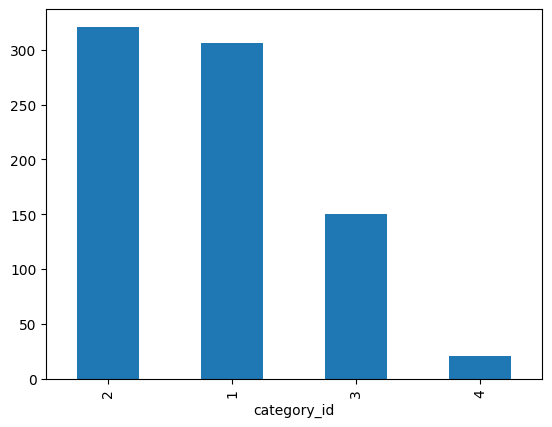

In [53]:
train_df.category_id.value_counts().plot(kind = "bar")

# Model Without Augmentation

In [54]:
# Convert pixel values to float32 and normalize them
X_train = np.array([get_pixels(train_images, x) for x in train_df["file_name"]], dtype=np.float32)
y_train = np.array(train_df.category_id - 1)

X_val = np.array([get_pixels(valid_images, x) for x in valid_df["file_name"]], dtype=np.float32)
y_val = np.array(valid_df.category_id - 1)


In [11]:
# Release the RAM used to store these dataframes
del train_df
del valid_df

gc.collect()

0

In [20]:
model = Sequential([
    # Block 1 : Number of filters : 16, kernel size = [3,3], activation = relu Params
    # Filter height : 3 , filter width : 3, input channels = 1, since gray scale
    # Total num of params for the first block is (3 * 3 )
    # Formula : Numfilters * (filter size * filter size * input channel + 1) = 16 * (3*3*1 + 1) = 160 params
    # The output shape will be ([Input Size - Filter Size + 2 * Padding] / Stride Size)  + 1
    # O = (640 - (3+2*0) / 1 + 1) = 635
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
    MaxPooling2D((2, 2)),
    # Block 2 : Number of filters : 16, kernel size = [3,3], activation = relu
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Block 3 : Number of filters : 16, kernel size = [3,3], activation = relu
    Conv2D(16, (3, 3), activation='relu'),
    Flatten(),
    # Block 1 : Number of filters : 16, kernel size = [1], activation = relu
    Dense(16, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # Last layer to classify the multiclassification problem
])

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
gc.collect()

0

In [24]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
25/25 [==============================] - 241s 10s/step - loss: 1.3738 - accuracy: 0.3960 - val_loss: 2.0393 - val_accuracy: 0.1308
Epoch 2/10
25/25 [==============================] - 261s 11s/step - loss: 1.0329 - accuracy: 0.5865 - val_loss: 2.7952 - val_accuracy: 0.1519
Epoch 3/10
25/25 [==============================] - 259s 10s/step - loss: 0.8662 - accuracy: 0.6278 - val_loss: 2.5193 - val_accuracy: 0.1941
Epoch 4/10
25/25 [==============================] - 271s 11s/step - loss: 0.6210 - accuracy: 0.7657 - val_loss: 2.2040 - val_accuracy: 0.1772
Epoch 5/10
25/25 [==============================] - 247s 10s/step - loss: 0.4874 - accuracy: 0.8195 - val_loss: 3.4923 - val_accuracy: 0.2700
Epoch 6/10
25/25 [==============================] - 255s 10s/step - loss: 0.3207 - accuracy: 0.8897 - val_loss: 3.8382 - val_accuracy: 0.2489
Epoch 7/10
25/25 [==============================] - 279s 11s/step - loss: 0.2133 - accuracy: 0.9261 - val_loss: 5.1509 - val_accuracy: 0.2700
Epoch 

Model might be overfitting due to high training accuracy but low validation accuracy. This might be due to prescence of imbalanced nature of our dataset

In [26]:
model.save('cnn_no_augment.hd5')

In [32]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/content/drive/MyDrive/cnn_no_augment.hd5")


In [33]:
del X_train
del X_val
del y_train
del y_val
gc.collect()

22998

In [34]:
test_df = get_pd_data(test_processed_image_annotations)

In [35]:
X_test = np.array([get_pixels(test_images, x) for x in test_df["file_name"]], dtype=np.float32)
y_test = np.array(test_df.category_id)

In [36]:
result = loaded_model.predict(X_test)

4/4 [==============================] - 10s 2s/step


In [37]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

# Get the predicted labels
predicted_labels = np.argmax(result, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_labels)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.11      0.24      0.15        17
           2       0.00      0.00      0.00        11
           3       0.75      0.10      0.18        30
           4       0.00      0.00      0.00        67

    accuracy                           0.06       125
   macro avg       0.17      0.07      0.07       125
weighted avg       0.20      0.06      0.06       125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

# Image Augmentation to Improve Model

In [37]:
import imgaug.augmenters as iaa

In [38]:
train_df = get_pd_data(train_processed_image_annotations)
valid_df = get_pd_data(valid_processed_image_annotations)

In [39]:
# Convert pixel values to float32 and normalize them
X_train = np.array([get_pixels(train_images, x) for x in train_df["file_name"]], dtype=np.float32)
y_train = np.array(train_df.category_id - 1)

X_val = np.array([get_pixels(valid_images, x) for x in valid_df["file_name"]], dtype=np.float32)
y_val = np.array(valid_df.category_id - 1)

In [40]:
# Release the RAM used to store these dataframes
del train_df
del valid_df

gc.collect()

13

In [42]:
# Since our data is gray scaled, we can only use these augmentations
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),  # Gaussian blur with random sigma
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # Add Gaussian noise
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.ShearX((-20, 20)),  # Shear along the x-axis
    iaa.ContrastNormalization((0.5, 1.5)),  # Contrast normalization
    iaa.Multiply((0.5, 1.5), per_channel=0.5),  # Multiply pixel values (brightness)
], random_order=True)

In [43]:
import numpy as np
import imgaug.augmenters as iaa

# Define augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),
    iaa.Affine(rotate=(-45, 45)),
    iaa.ShearX((-20, 20)),
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Multiply((0.5, 1.5), per_channel=0.5)
], random_order=True)

# Find unique values and their counts
unique_values, counts = np.unique(y_train, return_counts=True)

# Find the index of the maximum count
max_count_index = np.argmax(counts)

# Get the class ID with the maximum count
class_with_max_count = unique_values[max_count_index]

# Get the maximum count
max_count = counts[max_count_index]

augmented_X_train = []
augmented_y_train = []

# Include all samples from the class with the maximum count in augmented_X_train and augmented_y_train
max_count_indices = np.where(y_train == class_with_max_count)[0]
max_count_images = X_train[max_count_indices]
augmented_X_train.extend(max_count_images)
augmented_y_train.extend([class_with_max_count] * len(max_count_images))

# Loop through each class
for cls in unique_values:
    # Skip the class with the maximum count
    if cls == class_with_max_count:
        continue

    # Select images belonging to the minority class
    minority_indices = np.where(y_train == cls)[0]
    minority_images = X_train[minority_indices]

    # Calculate the number of samples to augment
    num_to_augment = max_count - len(minority_images)

    # Select random samples from the minority class for augmentation
    selected_indices = np.random.choice(minority_indices, size=num_to_augment, replace=True)
    selected_images = X_train[selected_indices]

    # Augment selected images
    augmented_images = [seq.augment_image(img) for img in selected_images]

    # Append augmented data to the lists
    augmented_X_train.extend(augmented_images)
    augmented_X_train.extend(minority_images)

    # Append labels
    augmented_y_train.extend([cls] * len(augmented_images))
    augmented_y_train.extend([cls] * len(minority_images))

# Convert lists to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Shuffle augmented data
shuffle_indices = np.random.permutation(len(augmented_X_train))
augmented_X_train = augmented_X_train[shuffle_indices]
augmented_y_train = augmented_y_train[shuffle_indices]


In [44]:
len(augmented_y_train)

1284

In [45]:
del seq
del X_train
del y_train
gc.collect()

0

In [46]:
model = Sequential([
    # Block 1 : Number of filters : 16, kernel size = [3,3], activation = relu Params
    # Filter height : 3 , filter width : 3, input channels = 1, since gray scale
    # Total num of params for the first block is (3 * 3 )
    # Formula : Numfilters * (filter size * filter size * input channel + 1) = 16 * (3*3*1 + 1) = 160 params
    # The output shape will be ([Input Size - Filter Size + 2 * Padding] / Stride Size)  + 1
    # O = (640 - (3+2*0) / 1 + 1) = 635
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
    MaxPooling2D((2, 2)),
    # Block 2 : Number of filters : 16, kernel size = [3,3], activation = relu
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Block 3 : Number of filters : 16, kernel size = [3,3], activation = relu
    Conv2D(32, (3, 3), activation='relu'),
    Flatten(),
    # Block 1 : Number of filters : 16, kernel size = [1], activation = relu
    Dense(16, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # Last layer to classify the multiclassification problem
])

In [47]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [50]:
batch_size = 60
epochs = 200
history = model.fit(augmented_X_train, augmented_y_train, steps_per_epoch = len(augmented_y_train)// batch_size,
    epochs = epochs, validation_data=(X_val, y_val),
    callbacks = [EarlyStopping()])

Epoch 1/200
21/21 [==============================] - 6s 272ms/step - loss: 0.4597 - accuracy: 0.8107 - val_loss: 2.1109 - val_accuracy: 0.3671
Epoch 2/200
21/21 [==============================] - 3s 156ms/step - loss: 0.4167 - accuracy: 0.8403 - val_loss: 2.5532 - val_accuracy: 0.2110
Epoch 3/200
21/21 [==============================] - 2s 91ms/step - loss: 0.4265 - accuracy: 0.8333 - val_loss: 2.3946 - val_accuracy: 0.2954
Epoch 4/200
21/21 [==============================] - 2s 86ms/step - loss: 0.4314 - accuracy: 0.8341 - val_loss: 2.7467 - val_accuracy: 0.2532
Epoch 5/200
21/21 [==============================] - 2s 90ms/step - loss: 0.4145 - accuracy: 0.8302 - val_loss: 2.6989 - val_accuracy: 0.2743
Epoch 6/200
21/21 [==============================] - 3s 133ms/step - loss: 0.3935 - accuracy: 0.8388 - val_loss: 3.0372 - val_accuracy: 0.2785
Epoch 7/200
21/21 [==============================] - 3s 120ms/step - loss: 0.3823 - accuracy: 0.8450 - val_loss: 2.6517 - val_accuracy: 0.2700
Ep

In [51]:
model.save('cnn_augment.hd5')


In [52]:
test_df = get_pd_data(test_processed_image_annotations)

In [53]:
X_test = np.array([get_pixels(test_images, x) for x in test_df["file_name"]], dtype=np.float32)
y_test = np.array(test_df.category_id)

In [54]:
result = model.predict(X_test)

4/4 [==============================] - 0s 14ms/step


In [56]:
# prompt: give me the code to get the classification report of predict vs test

import numpy as np
from sklearn.metrics import classification_report

# Get the predicted labels
predicted_labels = np.argmax(result, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_labels)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.29      0.41      0.34        17
           2       0.00      0.00      0.00        11
           3       0.38      0.40      0.39        30
           4       0.00      0.00      0.00        67

    accuracy                           0.15       125
   macro avg       0.13      0.16      0.15       125
weighted avg       0.13      0.15      0.14       125



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.